# Lecture FE04

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline
%load_ext autoreload
%autoreload 2

Install `tsfresh` with (Anaconda distribution)

    conda install -c conda-forge tsfresh

or

    pip install tsfresh
    

In [2]:
import tsfresh.examples.robot_execution_failures as robot
robot.download_robot_execution_failures()

import os
os.path.getsize(robot.data_file_name), robot.data_file_name

(27345,
 '/opt/anaconda3/envs/engsci712/lib/python3.11/site-packages/tsfresh/examples/data/robotfailure-mld/lp1.data')

In [3]:
ts, labels = robot.load_robot_execution_failures()
labels.value_counts()

False    67
True     21
Name: count, dtype: int64

In [4]:
labels.head()

1    True
2    True
3    True
4    True
5    True
dtype: bool

In [5]:
ts.head()

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0


<Axes: title={'center': 'Success example (id 3)'}, xlabel='time'>

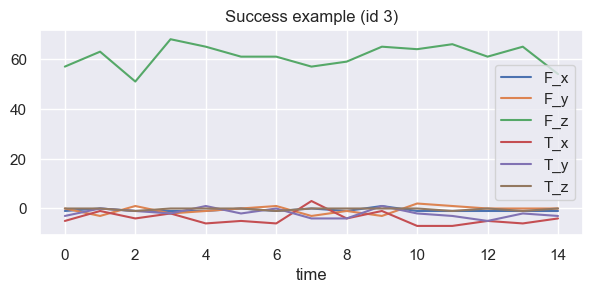

In [6]:
import seaborn as sns
%matplotlib inline

normal = ts[ts.id == 3][['time', 'F_x', 'F_y', 'F_z', 'T_x', 'T_y', 'T_z']]
normal.plot(x='time',
            title='Success example (id 3)', 
            figsize=(7, 0.381*7))

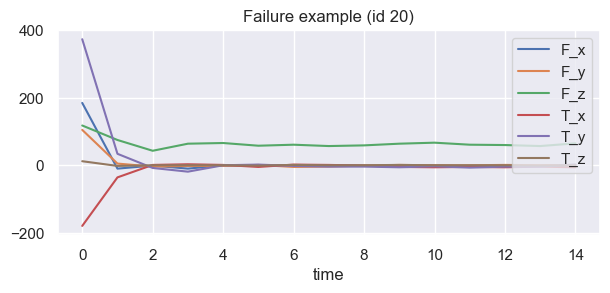

In [7]:
failure = ts[ts.id == 20][['time', 'F_x', 'F_y', 'F_z', 'T_x', 'T_y', 'T_z']]
ax = failure.plot(x='time',
             title='Failure example (id 20)', 
             figsize=(7, 0.381*7))
ax.legend(loc='upper right')

In [8]:
from tsfresh import extract_features
X = extract_features(ts, column_id='id',column_sort='time')

Feature Extraction: 100%|███████████████████████| 38/38 [00:05<00:00,  7.00it/s]


In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88 entries, 1 to 88
Columns: 4698 entries, T_y__variance_larger_than_standard_deviation to T_x__mean_n_absolute_max__number_of_maxima_7
dtypes: float64(4698)
memory usage: 3.2 MB


In [10]:
X.isna().sum()

T_y__variance_larger_than_standard_deviation               0
T_y__has_duplicate_max                                     0
T_y__has_duplicate_min                                     0
T_y__has_duplicate                                         0
T_y__sum_values                                            0
                                                          ..
T_x__permutation_entropy__dimension_5__tau_1               0
T_x__permutation_entropy__dimension_6__tau_1               0
T_x__permutation_entropy__dimension_7__tau_1               0
T_x__query_similarity_count__query_None__threshold_0.0    88
T_x__mean_n_absolute_max__number_of_maxima_7               0
Length: 4698, dtype: int64

In [11]:
Xreal = X.dropna(axis=1)  # drop columns with missing values (algorithm did not converge)
Xreal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88 entries, 1 to 88
Columns: 2214 entries, T_y__variance_larger_than_standard_deviation to T_x__mean_n_absolute_max__number_of_maxima_7
dtypes: float64(2214)
memory usage: 1.5 MB


In [12]:
from tsfresh.transformers import FeatureSelector

select = FeatureSelector()
select.fit(Xreal, labels)

FeatureSelector()

In [13]:
p_values = pd.Series(select.p_values, index=select.features)
p_values.head()

F_x__value_count__value_-1                      1.879633e-12
F_x__root_mean_square                           5.900086e-12
F_x__abs_energy                                 5.900086e-12
T_y__absolute_maximum                           5.966395e-12
F_x__mean_n_absolute_max__number_of_maxima_7    6.054628e-12
dtype: float64

In [14]:
np.alltrue(Xreal[select.relevant_features] == select.transform(Xreal))

True

In [15]:
Xrel = Xreal[select.relevant_features]

In [16]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(Xrel, labels)

DecisionTreeClassifier()

In [17]:
from sklearn.metrics import confusion_matrix

confusion_matrix(labels, clf.predict(Xrel))

array([[67,  0],
       [ 0, 21]])

In [18]:
clf2 = DecisionTreeClassifier(max_depth=2, random_state=0)
clf2.fit(Xreal[select.relevant_features], labels)

DecisionTreeClassifier(max_depth=2, random_state=0)

In [19]:
confusion_matrix(labels, clf2.predict(Xrel))

array([[67,  0],
       [ 0, 21]])

[Text(0.5, 0.75, 'F_x__abs_energy <= 68.5\ngini = 0.363\nsamples = 88\nvalue = [67, 21]'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 21\nvalue = [0, 21]'),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 67\nvalue = [67, 0]')]

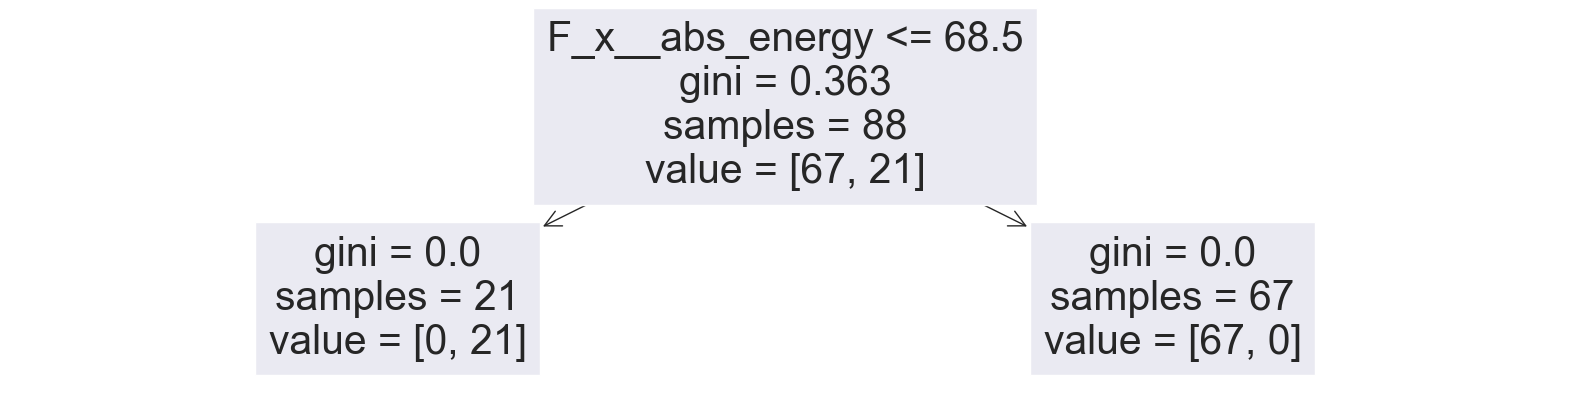

In [20]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20,5))
plot_tree(clf, feature_names=select.relevant_features, )

`F_x__abs_energy` = $\sum\limits_{j=1}^T F_x[j]^2$

Gini impurity of node $i$ is 

$G_i = 1 - \sum\limits_{k\in\mathcal{C}} p_{i,k}^2$

with $p_{i,k}$ is the ratio of class $k\in\mathcal{C}=\{\mathtt{True}, \mathtt{False}\}$ instances among the training instances in the $i^\text{th}$ node.

In [21]:
# Calculate Gini of top node
# np.sum(labels) counts the number of samples with label True
# np.sum(~labels) counts the number of samples with label False
1 - ((np.sum(labels)/88)**2      # k = True
     +(np.sum(~labels)/88)**2    # k = False
    )

0.3633780991735538

In [22]:
[f(Xrel['F_x__abs_energy'][labels]) for f in [min, max]]

[6.0, 62.0]

In [23]:
[f(Xrel['F_x__abs_energy'][~labels]) for f in [min, max]]

[75.0, 1405437.0]

# How good does this generalise?

In [24]:
from sklearn.model_selection import cross_val_predict

cross_val_predict(clf, Xrel, labels)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True, False,  True,  True,  True,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True])

In [25]:
confusion_matrix(labels, cross_val_predict(clf, Xrel, labels))

array([[65,  2],
       [ 2, 19]])